### === Task ===

1. With the iris data given in class, implement train_test_split from scratch.

2. Put everything into a class called LogisticRegression, this class should allow you choose any of the training methods you'd like including "batch", "minibatch" and "sto". However, if the input method is not one of the three, it should "raise ValueError".

3. Calculate time taken to fit your models using different training methods.

4. Perform a classification on the dataset using all 3 methods and also show what happens if your defined training method is not either "batch", "minibatch" or "sto". Make sure to plot the training losses.

5. Simply, use classification_report from sklearn.metrics to evaluate your models.

6. Discuss your results ie. training losses of the three methods and time taken to fit models.


In [20]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

#Step 1: Prepare data

# import some data to play with
iris = datasets.load_iris()

In [21]:
X = iris.data[:, 2:]  # we only take the first two features.
y = iris.target  #now our y is three classes thus require multinomial

In [22]:
# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
def Train_test_splitter(X,y,train_size = 0.7):
    a = np.arange(X.shape[0])
    np.random.shuffle(a)    
    m = X.shape[0]
    a_train = a[0:round(train_size*len(X))]
    a_test = a[len(a_train):]    
    X_train = X[a_train]
    y_train = y[a_train]
    X_test = X[a_test]    
    y_test = y[a_test]
    return X_train,X_test, y_train,y_test
    

In [24]:
X_train, X_test, y_train, y_test = Train_test_splitter(X, y, train_size=0.7)
X_train.shape

(105, 2)

In [25]:
X_test.shape

(45, 2)

In [26]:
# add intercept to our X
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)  #add intercept
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)  #add intercept

In [27]:
k = len(set(y))  # no. of class  (can also use np.unique)
m = X_train.shape[0]  # no.of samples
n = X_train.shape[1]  # no. of features
y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

In [28]:
y_train_encoded.shape

(105, 3)

In [83]:
class LogisticReg:
    def __init__(self, alpha=0.001, early_stopping = True, max_iter= 1000, 
            loss_old=10000, tol=1e-3, method="batch",batch_size = 100):
        
        self.alpha = alpha
        self.early_stopping = early_stopping
        self.max_iter = max_iter
        self.loss_old = 10000
        self.tol = tol
        self.method = method
        self.batch_size = batch_size
        
    def gradient(self,X,y):
        m = X.shape[0]
        h = self.h_theta(X)
        cost = - np.sum(y*np.log(h)) / m
        self.error = h - y
        grad = self.softmax_grad(X)
        return cost, grad    
    
    def h_theta(self, X):
        return self.softmax(X @ self.w)
    
    def softmax(self,x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def softmax_grad(self, X):
        return  X.T @ self.error
    
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test), axis=1)
        
    def fit(self,X,y):
        n = X.shape[1]
        k = y.shape[1]
        self.w = np.random.rand(n, k)
        l_rate =  self.alpha
        self.costList = []
        
        for j in range(self.max_iter):
            self.st_time = time.time()
            
            if self.method == 'batch':
                
                X_train = X
                y_train = y
                cost, grad =  self.gradient(X_train, y_train)
                self.costList.append(cost)
                if j % 500 == 0:
                    print(f"Cost at iteration {j}", cost)
                    
                self.w = self.w - l_rate * grad
            
                
            elif self.method == 'sto': #for stochastic method
               
                a = np.arange(X.shape[0])
                np.random.shuffle(a)
                for i in a:
                    X_stoc = X[i,:].reshape(1,-1)
                    y_stoc = y[i]                     
                    cost, grad = self.gradient(X_stoc, y_stoc)
                    self.costList.append(cost)
                    if j % 500 == 0:
                        print(f"Cost at iteration {j}", cost)
                        
                    self.w = self.w - l_rate * grad
                
                    
            elif self.method == 'mini': #for stochastic method
                n_batches = np.ceil(X.shape[0]/self.batch_size)
                last_batch = m%self.batch_size
                k = 0
                for i in range(int(n_batches)):    
                    if i != range(int(n_batches))[-1] : 
                        X_mini = X[k:k+self.batch_size]
                        y_mini = y[k:k+self.batch_size]
                        
                        cost, grad = self.gradient(X_mini, y_mini) 
                        self.costList.append(cost)

                        if j % 500 == 0:
                            print(f"Cost at iteration {j}", cost)
                            
                        self.w = self.w - l_rate * grad
                    
                    else:
                        X_mini = X[k:k+last_batch]
                        y_mini = y[k:k+last_batch]
                      
                        cost, grad = self.gradient(X_mini, y_mini)
                        if j % 500 == 0:
                            print(f"Cost at iteration {j}", cost)
                            
                        self.w = self.w - l_rate * grad
                        self.costList.append(cost)
            else:
                raise ValueError('Please type method as "batch", "mini" or "sto".')
        self.t = {time.time() - self.st_time}
        print(f"time taken: {time.time() - self.st_time}")
        
    def plot(self):
        plt.plot(np.arange(len(self.costList)) , self.costList, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()
        
    def time(self):
        print(f"time taken: {self.t}")


Cost at iteration 0 1.5358934839297007
Cost at iteration 500 0.17084130964484698
Cost at iteration 1000 0.12092650760210655
Cost at iteration 1500 0.10063209559774496
Cost at iteration 2000 0.08923419737037191
Cost at iteration 2500 0.08179917434451536
Cost at iteration 3000 0.0765098146054972
Cost at iteration 3500 0.07252770061301382
Cost at iteration 4000 0.0694078040162545
Cost at iteration 4500 0.0668900212629117
Cost at iteration 5000 0.06481122782003658
Cost at iteration 5500 0.06306345296049319
Cost at iteration 6000 0.06157212139919574
Cost at iteration 6500 0.060283914387582946
Cost at iteration 7000 0.059159606465647385
Cost at iteration 7500 0.05816963889428432
Cost at iteration 8000 0.057291276608574124
Cost at iteration 8500 0.05650672134996677
Cost at iteration 9000 0.05580182355315598
Cost at iteration 9500 0.055165181132733276
time taken: 5.91278076171875e-05


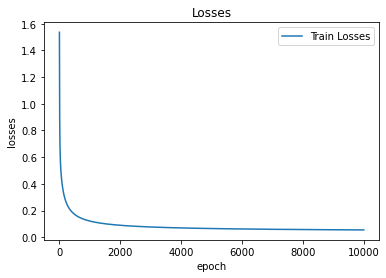

In [84]:
model = LogisticReg(max_iter= 10000, method = 'batch')
model.fit(X_train,y_train_encoded)
model.plot()

In [85]:
from sklearn.metrics import classification_report
yhat = model.predict(X_test)
print("Report: ", classification_report(yhat, y_test))

Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.88      0.88      0.88        16
           2       0.82      0.82      0.82        11

    accuracy                           0.91        45
   macro avg       0.90      0.90      0.90        45
weighted avg       0.91      0.91      0.91        45



In [86]:
model.time()

time taken: {5.2928924560546875e-05}


Cost at iteration 0 1.1620934339657822
Cost at iteration 0 0.6879376443723317
Cost at iteration 0 1.261158039591305
Cost at iteration 0 0.688893591263159
Cost at iteration 0 0.6957960980256688
Cost at iteration 0 0.6919967240865557
Cost at iteration 0 1.1443910621502227
Cost at iteration 0 1.275903271719302
Cost at iteration 0 0.6881958379079629
Cost at iteration 0 0.6986759121753084
Cost at iteration 0 1.241023538563759
Cost at iteration 0 0.7107006940729373
Cost at iteration 0 0.7064698469710675
Cost at iteration 0 0.6952120058458819
Cost at iteration 0 0.7019834994870894
Cost at iteration 0 1.2136788382064427
Cost at iteration 0 1.08029764645137
Cost at iteration 0 1.0844439741265932
Cost at iteration 0 1.127361795178285
Cost at iteration 0 0.7062414818742186
Cost at iteration 0 1.2551230768676405
Cost at iteration 0 1.1844656911667997
Cost at iteration 0 1.0812540924404364
Cost at iteration 0 1.0685719174817496
Cost at iteration 0 1.110147759058992
Cost at iteration 0 1.01945779478

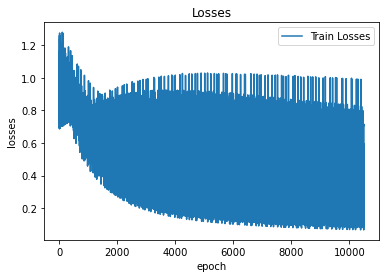

In [87]:
model2 = LogisticReg(max_iter= 100, method = 'sto') #here iteration is true epoch
model2.fit(X_train,y_train_encoded)
model2.plot()

In [88]:
yhat = model2.predict(X_test)
print("Report: ", classification_report(yhat, y_test))

Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.88      1.00      0.93        14
           2       1.00      0.85      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



Cost at iteration 0 1.231869409933929
Cost at iteration 0 1.068101970491283
Cost at iteration 500 0.169781467698591
Cost at iteration 500 0.10487094087297735
Cost at iteration 1000 0.12008062545124176
Cost at iteration 1000 0.07857015532912615
Cost at iteration 1500 0.10000946082310463
Cost at iteration 1500 0.06652430810067467
Cost at iteration 2000 0.0887760441880539
Cost at iteration 2000 0.05912461716235279
Cost at iteration 2500 0.08146362608570591
Cost at iteration 2500 0.053932381535059956
Cost at iteration 3000 0.07626867466620818
Cost at iteration 3000 0.05000454954032241
Cost at iteration 3500 0.07236144179907548
Cost at iteration 3500 0.04688618488816005
Cost at iteration 4000 0.06930243989226677
Cost at iteration 4000 0.04432564639374238
Cost at iteration 4500 0.06683523598354746
Cost at iteration 4500 0.04217017328126055
time taken: 9.918212890625e-05


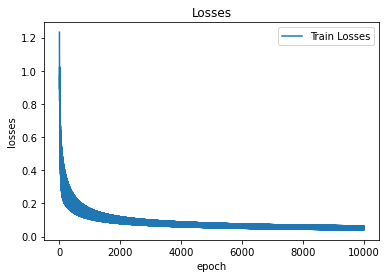

In [96]:
model3 = LogisticReg(max_iter= 5000, method = 'mini') #here iteration is true epoch
model3.fit(X_train,y_train_encoded)
model3.plot()

In [97]:
yhat = model3.predict(X_test)
print("Report: ", classification_report(yhat, y_test))

Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.88      0.88      0.88        16
           2       0.82      0.82      0.82        11

    accuracy                           0.91        45
   macro avg       0.90      0.90      0.90        45
weighted avg       0.91      0.91      0.91        45



In [91]:
model4 = LogisticReg(max_iter= 2000, method = 'gitgud') #here iteration is true epoch
model4.fit(X_train,y_train_encoded)
model4.plot()

ValueError: Please type method as "batch", "mini" or "sto".

====== for batch ====
time taken: {5.2928924560546875e-05}


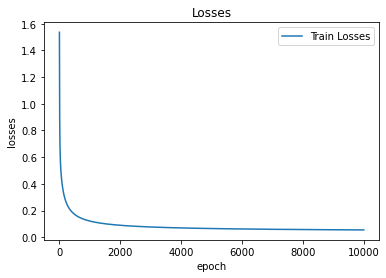

In [99]:
#The most stable loss with a smooth curveis of batch gradient descent as it looks at all of the data in one go.
#the loss elbows at around 1000 epochs. So any more than than doesn't yeild much better results
#it
print("====== for batch ====")
model.plot()
model.time()


====== for stochastic ====
time taken: {0.00365447998046875}


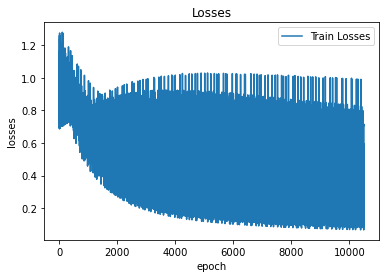

In [100]:
# Stochastic GD has the wildest curve as it only looks at one data at a time. 
#it is less computationaly heavy but highly unstable
# Although the overall loss is decreasing it oscillates back and forth too much
print("====== for stochastic ====")
model2.plot()
model2.time()

====== for mini batch ====
time taken: {9.72747802734375e-05}


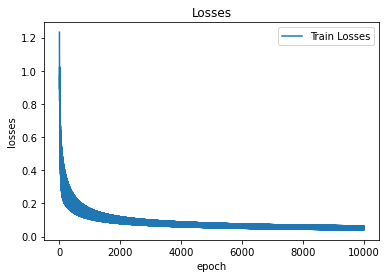

In [101]:
# Mini batch GD is the middle ground which takes in a small batch but not the entire batch
# Curve is mildy stable 
# It is less averagely computation heavy and stable
# Although the overall loss is decreasing it oscillates back and forth too much
print("====== for mini batch ====")
model3.plot()
model3.time()